### 데이터 전처리 실습1
    - 가상의 당뇨병 환자 데이터 생성

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 가상의 당뇨병 환자 데이터 생성
np.random.seed(0)
data = {
    'age': np.random.randint(20, 80, 100),
    'gender': np.random.choice(['M', 'F'], 100),
    'bmi': np.random.uniform(18.5, 35, 100),
    'blood_pressure': np.random.randint(80, 180, 100),
    'glucose_level': np.random.uniform(70, 200, 100),
    'insulin': np.random.uniform(15, 300, 100),
    'diabetes': np.random.choice([0, 1], 100, p=[0.7, 0.3])
}

df = pd.DataFrame(data)
df

,age,gender,bmi,blood_pressure,glucose_level,insulin,diabetes
0,64,F,30.111665,172,101.307741,68.332304,0
1,67,M,23.259861,123,83.038212,272.635427,0
2,73,M,25.649253,163,72.135852,169.984696,0
3,20,M,30.975760,129,190.838811,145.219755,1
4,23,F,25.035622,121,157.089151,266.381802,0
...,...,...,...,...,...,...,...
95,73,M,29.728987,160,158.581026,81.524773,0
96,32,M,19.907377,106,106.087493,211.583956,0
97,77,F,19.430902,115,86.751874,31.631562,0
98,62,M,26.549322,138,121.047838,223.252093,0


In [3]:
# 일부 데이터에 결측치 추가
df.loc[np.random.choice(df.index, 10), 'bmi'] = np.nan
df.loc[np.random.choice(df.index, 10), 'insulin'] = np.nan

print(df.head())
print("\n결측치 확인:\n", df.isnull().sum())

   age gender        bmi  blood_pressure  glucose_level     insulin  diabetes
0   64      F        NaN             172     101.307741   68.332304         0
1   67      M  23.259861             123      83.038212  272.635427         0
2   73      M  25.649253             163      72.135852  169.984696         0
3   20      M  30.975760             129     190.838811         NaN         1
4   23      F  25.035622             121     157.089151  266.381802         0

결측치 확인:
 age                0
gender             0
bmi               10
blood_pressure     0
glucose_level      0
insulin            9
diabetes           0
dtype: int64


#### Numeric, Categorical data

In [4]:
# 수치형 특성과 범주형 특성 구분
numeric_features = ['age', 'bmi', 'blood_pressure', 'glucose_level', 'insulin']
categorical_features = ['gender']

#### pipeline 구성

In [5]:
# 수치형 데이터 전처리 파이프라인
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [6]:
# 범주형 데이터 전처리 파이프라인
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [7]:
# ColumnTransformer를 사용하여 전체 전처리 파이프라인 생성
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#### pipeline 실행

In [8]:
# 전처리 파이프라인 실행
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_processed = preprocessor.fit_transform(X)

#### 전처리 데이터 DataFrame

In [11]:
# 전처리된 데이터를 DataFrame으로 변환
feature_names = (numeric_features + 
                 preprocessor.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())
X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)

print("\n전처리 후 데이터:")
X_processed_df.head()


전처리 후 데이터:


,age,bmi,blood_pressure,glucose_level,insulin,gender_M
0,0.853161,-0.083170,1.366927,-0.768111,-1.082794,0.0
1,1.019577,-0.738239,-0.389680,-1.235508,1.340039,1.0
2,1.352410,-0.204930,1.044285,-1.514428,0.122703,1.0
3,-1.587612,0.983938,-0.174585,1.522402,-0.166836,1.0
4,-1.421195,-0.341892,-0.461378,0.658969,1.265877,0.0


#### 상관관계 분석

In [13]:
# 상관관계 분석
correlation = X_processed_df.corr()
print("\n상관관계:\n", )
correlation


상관관계:



,age,bmi,blood_pressure,glucose_level,insulin,gender_M
age,1.000000,0.004653,-0.056098,-0.038344,-0.068286,-0.148564
bmi,0.004653,1.000000,0.084750,0.104160,0.196017,0.026513
blood_pressure,-0.056098,0.084750,1.000000,0.065595,-0.186989,0.161135
glucose_level,-0.038344,0.104160,0.065595,1.000000,0.007798,-0.148795
insulin,-0.068286,0.196017,-0.186989,0.007798,1.000000,-0.041859
gender_M,-0.148564,0.026513,0.161135,-0.148795,-0.041859,1.000000


#### 주요 특성(important feature)

In [14]:
# 주요 특성 선택 (상관관계 기반)
threshold = 0.5
important_features = correlation[abs(correlation['glucose_level']) > threshold].index
print("\n중요 특성:", important_features.tolist())


중요 특성: ['glucose_level']


### 데이터 전처리 실습2

#### 모듈 import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

#### UCI ML Repo.
    - 심장질환 데이터셋

In [3]:
# 심장질환 데이터셋 로드 (UCI Machine Learning Repository에서 제공하는 데이터셋 사용)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv(url, names=column_names, na_values='?')

print("원본 데이터:")
df.head()

원본 데이터:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


#### 결측치 확인

In [4]:
print("\n결측치 확인:\n", df.isnull().sum())


결측치 확인:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


#### 이상치 처리
    - RobustScaler: 이상치에 덜 민감한 스케일링 방식. 중앙값과 사분위값을 이용하여 스케일링.
        StandardScaler와 다르게 극단적인 값에 영향이 적다.
        데이터에 이상치가 많거나 정규분포를 따르지 않을 경우 사용

$$
    X\_scaled = (X- median) / IQR
$$

In [5]:
# 원본 데이터 확인
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [6]:
# 1. 이상치 처리 (RobustScaler 사용)
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
robust_scaler = RobustScaler()
df[numeric_features] = robust_scaler.fit_transform(df[numeric_features])
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,-0.120081,0.679868,3.158416,0.084488,0.088954,0.148515,0.990099,-0.104392,0.326733,0.149752,1.600660,0.672241,4.734219,0.937294
std,0.695282,0.467299,0.960126,0.879987,0.809014,0.356198,0.994971,0.703846,0.469794,0.725672,0.616226,0.937438,1.939706,1.228536
min,-2.076923,0.000000,1.000000,-1.800000,-1.796875,0.000000,0.000000,-2.523077,0.000000,-0.500000,1.000000,0.000000,3.000000,0.000000
25%,-0.615385,0.000000,3.000000,-0.500000,-0.468750,0.000000,0.000000,-0.600000,0.000000,-0.500000,1.000000,0.000000,3.000000,0.000000
50%,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000
75%,0.384615,1.000000,4.000000,0.500000,0.531250,0.000000,2.000000,0.400000,1.000000,0.500000,2.000000,1.000000,7.000000,2.000000
max,1.615385,1.000000,4.000000,3.500000,5.046875,1.000000,2.000000,1.507692,1.000000,3.375000,3.000000,3.000000,7.000000,4.000000


#### Advanced missing value process
    - KNN Imputer: KNN 알고리즘을 활용하여 결측치 주변의 데이터를 사용하여 결측치를 대체
            변수 간의 관계가 복잡하거나 단순 대체로 부족한 경우 사용

In [7]:
# 2. 고급 결측치 처리 (KNN Imputer 사용)
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df_imputed

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.538462,1.0,1.0,0.75,-0.125000,1.0,2.0,-0.092308,0.0,0.9375,3.0,0.0,6.0,0.0
1,0.846154,1.0,4.0,1.50,0.703125,0.0,2.0,-1.384615,1.0,0.4375,2.0,3.0,3.0,2.0
2,0.846154,1.0,4.0,-0.50,-0.187500,0.0,2.0,-0.738462,1.0,1.1250,2.0,2.0,7.0,1.0
3,-1.461538,1.0,3.0,0.00,0.140625,0.0,0.0,1.046154,0.0,1.6875,3.0,0.0,3.0,0.0
4,-1.153846,0.0,2.0,0.00,-0.578125,0.0,2.0,0.584615,0.0,0.3750,1.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.846154,1.0,1.0,-1.00,0.359375,0.0,0.0,-0.646154,0.0,0.2500,2.0,0.0,7.0,1.0
299,0.923077,1.0,4.0,0.70,-0.750000,1.0,0.0,-0.369231,0.0,1.6250,2.0,2.0,7.0,2.0
300,0.076923,1.0,4.0,0.00,-1.718750,0.0,0.0,-1.169231,1.0,0.2500,2.0,1.0,7.0,3.0
301,0.076923,0.0,2.0,0.00,-0.078125,0.0,2.0,0.646154,0.0,-0.5000,2.0,1.0,3.0,1.0


#### 범주형 변수 처리
    - Label Encoding

In [8]:
# 3. 범주형 변수 처리 (Label Encoding)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
label_encoder = LabelEncoder()
for feature in categorical_features:
    df_imputed[feature] = label_encoder.fit_transform(df_imputed[feature].astype(str))

df_imputed

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,0.538462,1,0,0.75,-0.125000,1,2,-0.092308,0,0.9375,2,0.0,2,0.0
1,0.846154,1,3,1.50,0.703125,0,2,-1.384615,1,0.4375,1,3.0,0,2.0
2,0.846154,1,3,-0.50,-0.187500,0,2,-0.738462,1,1.1250,1,2.0,3,1.0
3,-1.461538,1,2,0.00,0.140625,0,0,1.046154,0,1.6875,2,0.0,0,0.0
4,-1.153846,0,1,0.00,-0.578125,0,2,0.584615,0,0.3750,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.846154,1,0,-1.00,0.359375,0,0,-0.646154,0,0.2500,1,0.0,3,1.0
299,0.923077,1,3,0.70,-0.750000,1,0,-0.369231,0,1.6250,1,2.0,3,2.0
300,0.076923,1,3,0.00,-1.718750,0,0,-1.169231,1,0.2500,1,1.0,3,3.0
301,0.076923,0,1,0.00,-0.078125,0,2,0.646154,0,-0.5000,1,1.0,0,1.0


#### 새로운 특성 생성

In [11]:
# 4. 새로운 특성 생성
df_imputed['heart_rate_pressure_product'] = df_imputed['thalach'] * df_imputed['trestbps']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,bmi,heart_rate_pressure_product
0,0.538462,1,0,0.75,-0.125000,1,2,-0.092308,0,0.9375,2,0.0,2,0.0,25867.346939,-0.069231
1,0.846154,1,3,1.50,0.703125,0,2,-1.384615,1,0.4375,1,3.0,0,2.0,20950.413223,-2.076923
2,0.846154,1,3,-0.50,-0.187500,0,2,-0.738462,1,1.1250,1,2.0,3,1.0,-6983.471074,0.369231
3,-1.461538,1,2,0.00,0.140625,0,0,1.046154,0,1.6875,2,0.0,0,0.0,0.000000,0.000000
4,-1.153846,0,1,0.00,-0.578125,0,2,0.584615,0,0.3750,0,0.0,0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.846154,1,0,-1.00,0.359375,0,0,-0.646154,0,0.2500,1,0.0,3,1.0,-13966.942149,0.646154
299,0.923077,1,3,0.70,-0.750000,1,0,-0.369231,0,1.6250,1,2.0,3,2.0,8215.277778,-0.258462
300,0.076923,1,3,0.00,-1.718750,0,0,-1.169231,1,0.2500,1,1.0,3,3.0,0.000000,-0.000000
301,0.076923,0,1,0.00,-0.078125,0,2,0.646154,0,-0.5000,1,1.0,0,1.0,0.000000,0.000000


In [13]:
df_imputed

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,heart_rate_pressure_product
0,0.538462,1,0,0.75,-0.125000,1,2,-0.092308,0,0.9375,2,0.0,2,0.0,-0.069231
1,0.846154,1,3,1.50,0.703125,0,2,-1.384615,1,0.4375,1,3.0,0,2.0,-2.076923
2,0.846154,1,3,-0.50,-0.187500,0,2,-0.738462,1,1.1250,1,2.0,3,1.0,0.369231
3,-1.461538,1,2,0.00,0.140625,0,0,1.046154,0,1.6875,2,0.0,0,0.0,0.000000
4,-1.153846,0,1,0.00,-0.578125,0,2,0.584615,0,0.3750,0,0.0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.846154,1,0,-1.00,0.359375,0,0,-0.646154,0,0.2500,1,0.0,3,1.0,0.646154
299,0.923077,1,3,0.70,-0.750000,1,0,-0.369231,0,1.6250,1,2.0,3,2.0,-0.258462
300,0.076923,1,3,0.00,-1.718750,0,0,-1.169231,1,0.2500,1,1.0,3,3.0,-0.000000
301,0.076923,0,1,0.00,-0.078125,0,2,0.646154,0,-0.5000,1,1.0,0,1.0,0.000000


#### 낮은 분산 특성 제거
    - 변화가 없는 특성을 제거
    - 분산이 낮은 것은 정보를 제공하는 양이 적다는 뜻
    - 불필요 특성을 제거하여 복잡성을 낮춤
    - 다중공선성(VIC)를 낮추는 방안

In [14]:
# 5. 낮은 분산 특성 제거
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df_imputed)
selected_feature_names = df_imputed.columns[selector.get_support()].tolist()
df_selected = pd.DataFrame(selected_features, columns=selected_feature_names)

df_selected

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,heart_rate_pressure_product
0,0.538462,1.0,0.0,0.75,-0.125000,1.0,2.0,-0.092308,0.0,0.9375,2.0,0.0,2.0,0.0,-0.069231
1,0.846154,1.0,3.0,1.50,0.703125,0.0,2.0,-1.384615,1.0,0.4375,1.0,3.0,0.0,2.0,-2.076923
2,0.846154,1.0,3.0,-0.50,-0.187500,0.0,2.0,-0.738462,1.0,1.1250,1.0,2.0,3.0,1.0,0.369231
3,-1.461538,1.0,2.0,0.00,0.140625,0.0,0.0,1.046154,0.0,1.6875,2.0,0.0,0.0,0.0,0.000000
4,-1.153846,0.0,1.0,0.00,-0.578125,0.0,2.0,0.584615,0.0,0.3750,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.846154,1.0,0.0,-1.00,0.359375,0.0,0.0,-0.646154,0.0,0.2500,1.0,0.0,3.0,1.0,0.646154
299,0.923077,1.0,3.0,0.70,-0.750000,1.0,0.0,-0.369231,0.0,1.6250,1.0,2.0,3.0,2.0,-0.258462
300,0.076923,1.0,3.0,0.00,-1.718750,0.0,0.0,-1.169231,1.0,0.2500,1.0,1.0,3.0,3.0,-0.000000
301,0.076923,0.0,1.0,0.00,-0.078125,0.0,2.0,0.646154,0.0,-0.5000,1.0,1.0,0.0,1.0,0.000000


#### PCA, 차원축소
    - 고차원의 데이터를 축소하여 낮은 차원으로 변환
    - 주성분이 전체 데이터의 분산을 얼마나 설명하는지 확인 가능
    - 원본 데이터의 특성을 선형 결합(linear combination)을 통해 새로운 특성을 생성
        --> 비 선형 관계에 대해 잘 파악하지 못할 수 있다.
        --> 도메인 지식이 필요함
        --> 원본의 직접적인 중요도를 파악하기 어렵다.

[PCA](https://youtu.be/FgakZw6K1QQ?si=Ahd99yFMK5BA2mAi)

In [15]:
# 6. 차원 축소 (PCA)
pca = PCA(n_components=0.95)  # 95% 분산 유지
pca_features = pca.fit_transform(df_selected)

#### 데이터 분할

In [16]:
# 7. 데이터 분할
X = df_selected.drop('num', axis=1)
y = df_selected['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
print("\n전처리 후 데이터:")
print(df_selected.head())
print("\nPCA 후 특성 수:", pca_features.shape[1])
print("\n훈련 데이터 shape:", X_train.shape)
print("테스트 데이터 shape:", X_test.shape)


전처리 후 데이터:
        age  sex   cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  0.538462  1.0  0.0      0.75 -0.125000  1.0      2.0 -0.092308    0.0   
1  0.846154  1.0  3.0      1.50  0.703125  0.0      2.0 -1.384615    1.0   
2  0.846154  1.0  3.0     -0.50 -0.187500  0.0      2.0 -0.738462    1.0   
3 -1.461538  1.0  2.0      0.00  0.140625  0.0      0.0  1.046154    0.0   
4 -1.153846  0.0  1.0      0.00 -0.578125  0.0      2.0  0.584615    0.0   

   oldpeak  slope   ca  thal  num  heart_rate_pressure_product  
0   0.9375    2.0  0.0   2.0  0.0                    -0.069231  
1   0.4375    1.0  3.0   0.0  2.0                    -2.076923  
2   1.1250    1.0  2.0   3.0  1.0                     0.369231  
3   1.6875    2.0  0.0   0.0  0.0                     0.000000  
4   0.3750    0.0  0.0   0.0  0.0                     0.000000  

PCA 후 특성 수: 12

훈련 데이터 shape: (242, 14)
테스트 데이터 shape: (61, 14)


### 데이터 전처리 실습2(수정)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.980123 -1.141086  1.180287  1.032257 -2.190820 -0.103246 -1.329377   
1  1.485650  3.321220 -2.401417  1.856481  0.349470 -1.251705  0.261555   
2 -0.997305  3.192087 -0.092712 -0.192273 -0.050469  1.049641  0.113128   
3 -0.523186 -2.091603  0.278785 -0.096649  0.518180 -0.940400 -0.809542   
4 -0.471493 -2.469850 -0.447615  0.667280 -0.434524  0.687197 -1.105184   

        PC8       PC9  
0  0.660263 -1.342423  
1 -0.501040 -0.146821  
2 -0.121826 -1.594240  
3  0.696918  0.397364  
4 -0.247662  0.359317  

PCA 후 특성 수: 9

PCA 설명된 분산 비율: [0.59517552 0.15368454 0.06163716 0.03600557 0.02925258 0.02400534
 0.02124353 0.01616417 0.01598448]

PCA 누적 설명 분산 비율: [0.59517552 0.74886006 0.81049722 0.84650279 0.87575537 0.89976071
 0.92100424 0.93716842 0.9531529 ]

특성 중요도 (상위 5개):
     feature  importance
12      thal    2.317606
13       num    2.310673
3   trestbps    2.267989
4       chol    2.071498
2         

C:\Users\seoju\AppData\Local\Temp\ipykernel_28872\3700945238.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

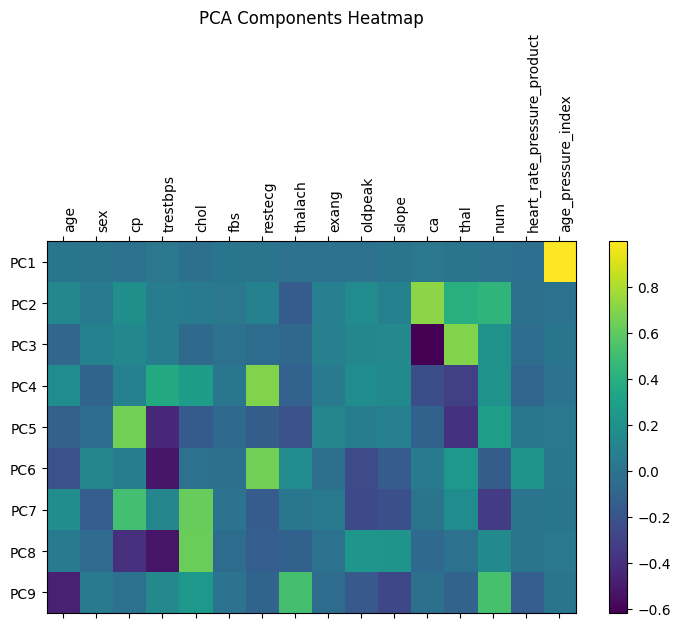

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# 심장질환 데이터셋 로드
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv(url, names=column_names, na_values='?')

# 1. 이상치 처리 (RobustScaler)
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
robust_scaler = RobustScaler()
df[numeric_features] = robust_scaler.fit_transform(df[numeric_features])

# 2. 결측치 처리 (KNN Imputer)
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 3. 범주형 변수 처리 (Label Encoding)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
label_encoder = LabelEncoder()
for feature in categorical_features:
    df_imputed[feature] = label_encoder.fit_transform(df_imputed[feature].astype(str))

# 4. 새로운 특성 생성 
df_imputed['heart_rate_pressure_product'] = df_imputed['thalach'] * df_imputed['trestbps']
df_imputed['age_pressure_index'] = np.where(df_imputed['age'] != 0, df_imputed['trestbps'] / df_imputed['age'], 0)
df_imputed = df_imputed.replace([np.inf, -np.inf], np.nan).fillna(0) # 무한대 값을 NaN으로 변경하고, NaN을 0으로 대체

# 5. 낮은 분산 특성 제거
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df_imputed)
selected_feature_names = df_imputed.columns[selector.get_support()].tolist()
df_selected = pd.DataFrame(selected_features, columns=selected_feature_names)

# 6. 차원 축소 (PCA)
pca = PCA(n_components=0.95)  # 95% 분산 유지
pca_features = pca.fit_transform(df_selected)

# PCA 이전의 특성 이름 저장
original_feature_names = df_selected.columns.tolist()

# 7. 데이터 분할
X = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
y = df_selected['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.head())
print("\nPCA 후 특성 수:", pca_features.shape[1])

# PCA 결과 분석
print("\nPCA 설명된 분산 비율:", pca.explained_variance_ratio_)
print("\nPCA 누적 설명 분산 비율:", np.cumsum(pca.explained_variance_ratio_))

# 특성 중요도
feature_importance = np.sum(np.abs(pca.components_), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': original_feature_names[:len(feature_importance)], 
    'importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("\n특성 중요도 (상위 5개):")
print(feature_importance_df.head())

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.matshow(pca.components_, cmap='viridis', aspect='auto')
plt.yticks(range(pca_features.shape[1]), [f'PC{i+1}' for i in range(pca_features.shape[1])])
plt.colorbar()
plt.xticks(range(len(original_feature_names[:len(feature_importance)])), 
           original_feature_names[:len(feature_importance)], rotation=90, ha='left')
plt.tight_layout()
plt.title("PCA Components Heatmap")
plt.show()